https://www.kaggle.com/code/jhoward/the-best-vision-models-for-fine-tuning#Analysis 

In [ ]:
# install fastkaggle if not available
try: import fastkaggle
except ModuleNotFoundError:
    !pip install -q fastkaggle

from fastkaggle import *


In [1]:
import timm
from fastkaggle import *


In [2]:
comp = 'paddy-disease-classification'
path = setup_comp(comp, install='"fastcore>=1.4.5" "fastai>=2.7.1" "timm>=0.6.2.dev0"')

In [4]:
path 

Path('paddy-disease-classification')

In [5]:
from fastai.vision.all import *
set_seed(42)

path.ls()

(#4) [Path('paddy-disease-classification/test_images'),Path('paddy-disease-classification/train.csv'),Path('paddy-disease-classification/train_images'),Path('paddy-disease-classification/sample_submission.csv')]

In [6]:
trn_path = path/'train_images'
files = get_image_files(trn_path)

(480, 640)


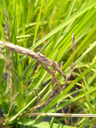

In [7]:
img = PILImage.create(files[0])
print(img.size)
img.to_thumb(128)

In [8]:
from fastcore.parallel import *

def f(o): return PILImage.create(o).size
sizes = parallel(f, files, n_workers=8)
pd.Series(sizes).value_counts()

(480, 640)    10403
(640, 480)        4
dtype: int64

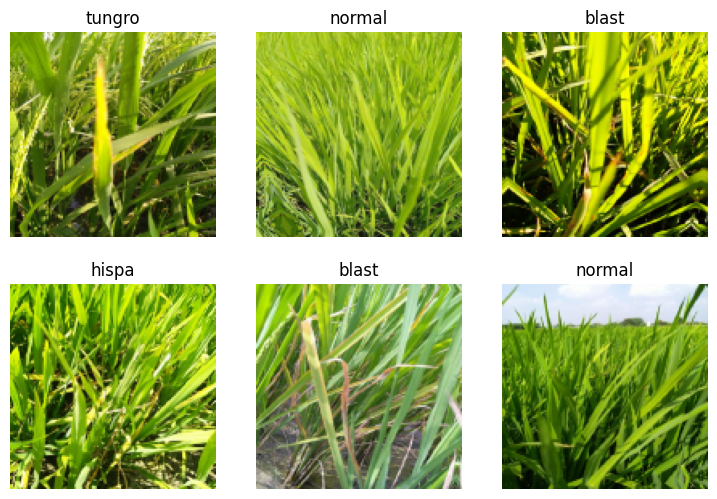

In [9]:
dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.2, seed=42,
    item_tfms=Resize(480, method='squish'),
    batch_tfms=aug_transforms(size=128, min_scale=0.75))

dls.show_batch(max_n=6)

In [10]:
learn = vision_learner(dls, 'resnet26d', metrics=error_rate, path='.').to_fp16()


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet26d-69e92c46.pth" to /Users/ash/.cache/torch/hub/checkpoints/resnet26d-69e92c46.pth


/Users/ash/ak/code/fastai/paddy/.venv/lib/python3.10/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/Users/ash/ak/code/fastai/paddy/.venv/lib/python3.10/site-packages/torch/cuda/amp/grad_scaler.py:118: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


SuggestedLRs(valley=0.0010000000474974513, slide=0.005248074419796467)

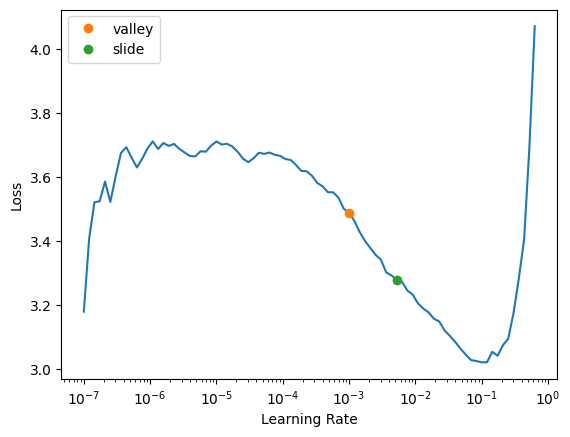

In [11]:
learn.lr_find(suggest_funcs=(valley, slide))


In [13]:
learn.fine_tune(3, 0.01)


epoch,train_loss,valid_loss,error_rate,time
0,1.776870,1.324117,0.392600,07:43


epoch,train_loss,valid_loss,error_rate,time
0,1.125546,0.755706,0.252763,09:18
1,0.771338,0.463167,0.144642,08:46
2,0.556405,0.387098,0.113888,09:05


In [16]:
ss = pd.read_csv(path/'sample_submission.csv')
ss

,image_id,label
0,200001.jpg,NaN
1,200002.jpg,NaN
2,200003.jpg,NaN
3,200004.jpg,NaN
4,200005.jpg,NaN
...,...,...
3464,203465.jpg,NaN
3465,203466.jpg,NaN
3466,203467.jpg,NaN
3467,203468.jpg,NaN


In [17]:
tst_files = get_image_files(path/'test_images').sorted()
tst_dl = dls.test_dl(tst_files)

In [18]:
probs,_,idxs = learn.get_preds(dl=tst_dl, with_decoded=True)
idxs

/Users/ash/ak/code/fastai/paddy/.venv/lib/python3.10/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/Users/ash/ak/code/fastai/paddy/.venv/lib/python3.10/site-packages/torch/cuda/amp/grad_scaler.py:118: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


TensorBase([7, 8, 7,  ..., 8, 1, 5])

In [19]:
dls.vocab


['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']

In [20]:
mapping = dict(enumerate(dls.vocab))
results = pd.Series(idxs.numpy(), name="idxs").map(mapping)
results

0                       hispa
1                      normal
2                       hispa
3                       blast
4                       blast
                ...          
3464               dead_heart
3465                    hispa
3466                   normal
3467    bacterial_leaf_streak
3468               dead_heart
Name: idxs, Length: 3469, dtype: object

In [21]:
ss['label'] = results
ss.to_csv('subm.csv', index=False)
!head subm.csv

image_id,label
200001.jpg,hispa
200002.jpg,normal
200003.jpg,hispa
200004.jpg,blast
200005.jpg,blast
200006.jpg,brown_spot
200007.jpg,dead_heart
200008.jpg,brown_spot
200009.jpg,hispa


In [22]:
if not iskaggle:.
    from kaggle import api
    api.competition_submit_cli('subm.csv', 'initial rn26d 128px', comp)

100%|██████████| 69.9k/69.9k [00:01<00:00, 37.2kB/s]


In [23]:
if not iskaggle:
    push_notebook('khatkeashish', 'jeremy-first-steps-road-to-the-top-part-1',
                  title='First Steps: Road to the Top, Part 1',
                  file='01.ipynb',
                  competition=comp, private=False, gpu=True)

Your kernel title does not resolve to the specified id. This may result in surprising behavior. We suggest making your title something that resolves to the specified id. See https://en.wikipedia.org/wiki/Clean_URL#Slug for more information on how slugs are determined.
Kernel version 1 successfully pushed.  Please check progress at https://www.kaggle.com/code/khatkeashish/first-steps-road-to-the-top-part-1


In [25]:
push_notebook?

Signature:
push_notebook(
    user,
    id,
    title,
    file,
    path='.',
    competition=None,
    private=True,
    gpu=False,
    internet=True,
)
Docstring: Push notebook `file` to Kaggle Notebooks
File:      ~/ak/code/fastai/paddy/.venv/lib/python3.10/site-packages/fastkaggle/core.py
Type:      function
